In [1]:
import drawing
# import imp
# imp.reload(drawing)

In [5]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:0


In [6]:
from collections import defaultdict

data_dir = "data"
alphabet = [
    '\x00', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
    '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
]
alphabet_ord = list(map(ord, alphabet))
alpha_to_num = defaultdict(int, list(map(reversed, enumerate(alphabet))))
num_to_alpha = defaultdict(int, list(enumerate(alphabet)))


In [107]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

In [108]:
strokes = np.load(os.path.join(data_dir, 'x.npy'))
stroke_lens = np.load(os.path.join(data_dir, 'x_len.npy'))
texts = np.load(os.path.join(data_dir, 'c.npy'))
text_lens = np.load(os.path.join(data_dir, 'c_len.npy'))
w_id = np.load(os.path.join(data_dir, 'w_id.npy'))

In [109]:
mean = np.mean(strokes[:, :, 0:2])
stddev = np.std(strokes[:, :, 0:2])
print(mean, stddev)

valid = np.zeros((stroke_lens.sum(), 2))
l = 0
for i in range(strokes.shape[0]):
    valid[l:l+stroke_lens[i], :] = strokes[i, :stroke_lens[i], 0:2]
    l += stroke_lens[i]  
    


# strokes[:,:,0:2] = (strokes[:,:,0:2] - mean)/stddev
# print(np.mean(strokes[:, :, 0:2]), np.std(strokes[:, :, 0:2]))


0.11109939 1.4914471


In [110]:
m0 = valid[:, 0].mean()
m1 = valid[:, 1].mean()
s0 = valid[:, 0].std()
s1 = valid[:, 1].std()

for i in range(strokes.shape[0]):
    strokes[i,:stroke_lens[i], 0] = (strokes[i,:stroke_lens[i], 0] - m0)/s0
    strokes[i,:stroke_lens[i], 1] = (strokes[i,:stroke_lens[i], 1] - m1)/s1

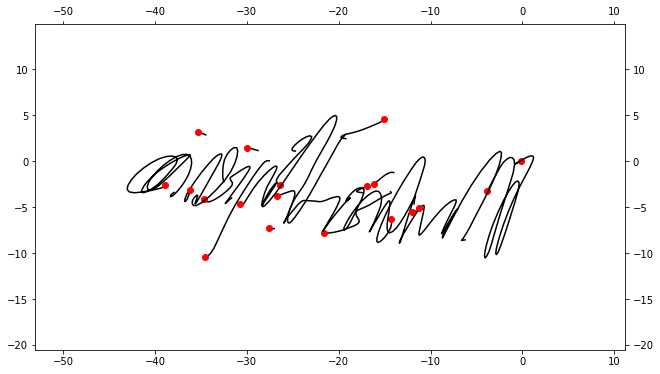

What 's new? This piece
drawing length: 674, text_length: 24


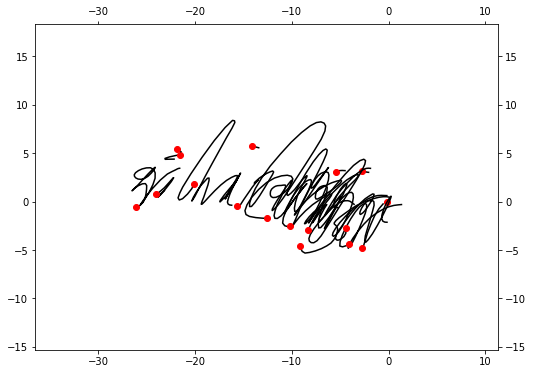

is a rich and rare combination
drawing length: 721, text_length: 31


In [111]:
for i in range(2):
    draw(strokes[i])
    print(drawing.decode_ascii(texts[i]))
    print(f"drawing length: {stroke_lens[i]}, text_length: {text_lens[i]}")

In [9]:
text_indexed = torch.tensor(texts)
max_text_len = max(text_lens)
print(max_text_len)
max_index = torch.max(text_indexed)
print(max_index)

65
tensor(72, dtype=torch.int8)


In [10]:
text_one_hots = torch.zeros((len(texts), max_text_len, max_index + 1))
text_masks = torch.ones((len(texts), max_text_len))
for i, string in enumerate(texts):
    for j, c in enumerate(string[:max_text_len]):
        text_one_hots[i, j, c] = 1
    text_masks[i, text_lens[i]:] = 0
    
text_one_hots.shape
text_masks.shape


torch.Size([11911, 65, 73])

torch.Size([11911, 65])

In [11]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [12]:
class HandwritingDataset(Dataset):
    def __init__(self,
                 strokes,
                 stroke_lengths,
                 text_one_hots,
                 text_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.text_one_hots = text_one_hots
        self.text_lengths = text_lengths
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.text_one_hots[idx], self.text_lengths[idx]
    
train_dataset = HandwritingDataset(
    strokes[:10000],
    stroke_lens[:10000],
    text_one_hots[:10000],
    text_lens[:10000])
test_dataset = HandwritingDataset(
    strokes[10000:],
    stroke_lens[10000:],
    text_one_hots[10000:],
    text_lens[10000:])

In [13]:
class HandWritingSynthesis(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 vocab_size,
                 n_output_mixtures,
                 n_attn_mixtures):
        super(HandWritingSynthesis, self).__init__()
        # input params
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output_mixtures = n_output_mixtures
        self.n_attn_mixtures = n_attn_mixtures
        self.vocab_size = vocab_size
        
        # inferred sizes of layer params
        self.output_size = 6*n_output_mixtures+1
        self.n_attn_params = 3*n_attn_mixtures
        
        # Layers needed
        
        # First LSTM layer
        self.lstm1 = nn.LSTMCell(
            input_size+vocab_size, hidden_size)
        
        # Layer to compute attn params from hidden state
        self.attn_params = nn.Linear(hidden_size, self.n_attn_params)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTMCell(
            input_size+hidden_size+vocab_size, hidden_size)
        
        # Layer to compute params for output gaussian
        self.output_params = nn.Linear(
            2*hidden_size, self.output_size)
        
        
    def forward(self,
                stroke_point,     # (batch, input_size=3)
                text_onehot,      # (batch, max_text_len, vocab_size)
                text_length,      # (batch, 1)
                h1_prev, c1_prev, # (batch, hidden_size)
                h2_prev, c2_prev, # (batch, hidden_size)
                attn_prev,        # (batch, vocab_size)
                attn_kappa_old):  # (batch, n_attn_mixtures)
        
        # First LSTM Layer
        h1_new, c1_new = self.lstm1(
            torch.cat((stroke_point, attn_prev), dim=-1).to(device),
            (h1_prev, c1_prev))
        
        # Attention calculations
        attn_params = self.attn_params(h1_new) # (batch, n_attn_params)
        
        attn_new, attn_kappa_new, phi_new = self.calculate_attn(
            attn_params, text_onehot, text_length, attn_kappa_old) 
        
        # Second LSTM layer
        h2_new, c2_new = self.lstm2(
            torch.cat((stroke_point, h1_new, attn_new), dim=-1).to(device),
            (h2_prev, c2_prev))
        
        out_params = self.output_params(torch.cat((h1_new, h2_new), dim=-1).to(device))
        
        return out_params, h1_new, c1_new, h2_new, c2_new, attn_new, attn_kappa_new, phi_new
    
    def calculate_attn(self, attn_params, text_onehot, text_length, attn_kappa_old):
        alpha = torch.exp(attn_params[:, :self.n_attn_mixtures])
        beta = torch.exp(attn_params[:, self.n_attn_mixtures:2*self.n_attn_mixtures])
#         print(attn_kappa_old.shape)
#         print(torch.exp(attn_params[:, 2*self.n_attn_mixtures:]).shape)
        kappa = attn_kappa_old + torch.exp(attn_params[:, 2*self.n_attn_mixtures:])
        
        def get_phi(i):
#             print(beta.shape, kappa.shape, alpha.shape)
            return torch.sum(alpha * torch.exp(-beta * (kappa - i)**2), -1)
        
        max_len = torch.max(text_length)
        phi = torch.zeros(alpha.shape[0], max_len, device=device)
        for i in range(max_len):
            phi[:,i] = get_phi(i)
#         print(phi)
#         print(text_onehot[:,:max_len,:].shape)
#         print(phi.unsqueeze(-1).shape)
#         print((text_onehot[:,:max_len,:]*phi.unsqueeze(-1)).shape)
        attn = torch.sum(text_onehot[:,:max_len,:]*phi.unsqueeze(-1), axis=1)
#         print(attn)
#         print(attn.shape)
        return attn, kappa, phi
        

In [40]:
a = torch.ones(4, 3)
a[:, 2] = 3
a[:, 1] = 2
b = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]])
a 
b
bs = 5
K = 3
tl = 9
kappa = torch.randn(bs, K)
alpha = torch.randn(bs, K)
beta = torch.randn(bs, K)
kappa
kappa.shape
kappa.repeat(1,  tl)
torch.arange(1, 10).repeat(3,1).repeat(5,1,1)

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])

tensor([[1, 2],
        [2, 3],
        [3, 4],
        [4, 5]])

tensor([[ 0.0286,  1.6878,  1.4000],
        [-0.2413,  1.3780,  2.3285],
        [-1.4295, -0.5591, -0.5830],
        [-0.5502, -0.8044, -1.6455],
        [-2.2445, -0.7941, -1.2393]])

torch.Size([5, 3])

tensor([[ 0.0286,  1.6878,  1.4000,  0.0286,  1.6878,  1.4000,  0.0286,  1.6878,
          1.4000,  0.0286,  1.6878,  1.4000,  0.0286,  1.6878,  1.4000,  0.0286,
          1.6878,  1.4000,  0.0286,  1.6878,  1.4000,  0.0286,  1.6878,  1.4000,
          0.0286,  1.6878,  1.4000],
        [-0.2413,  1.3780,  2.3285, -0.2413,  1.3780,  2.3285, -0.2413,  1.3780,
          2.3285, -0.2413,  1.3780,  2.3285, -0.2413,  1.3780,  2.3285, -0.2413,
          1.3780,  2.3285, -0.2413,  1.3780,  2.3285, -0.2413,  1.3780,  2.3285,
         -0.2413,  1.3780,  2.3285],
        [-1.4295, -0.5591, -0.5830, -1.4295, -0.5591, -0.5830, -1.4295, -0.5591,
         -0.5830, -1.4295, -0.5591, -0.5830, -1.4295, -0.5591, -0.5830, -1.4295,
         -0.5591, -0.5830, -1.4295, -0.5591, -0.5830, -1.4295, -0.5591, -0.5830,
         -1.4295, -0.5591, -0.5830],
        [-0.5502, -0.8044, -1.6455, -0.5502, -0.8044, -1.6455, -0.5502, -0.8044,
         -1.6455, -0.5502, -0.8044, -1.6455, -0.5502, -0.8044, -1.6455, -0.5502

tensor([[[1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9]],

        [[1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9]],

        [[1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9]],

        [[1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9]],

        [[1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9],
         [1, 2, 3, 4, 5, 6, 7, 8, 9]]])

In [55]:
def negative_log_likelihood(batch_params,       # (batch_size, 6*n_output_mixtures+1)
                            batch_targets,      # (batch_size, 3)
                            n_output_mixtures,
                            args):  
    batch_size = batch_params.shape[0]
    
    K = args["n_output_mixtures"]

    # end of stroke probability, last colmn in the params
    es = 1/(1 + torch.exp(batch_params[:,-1]))    # (batch_size, 1)
    
    # mixture weights
    pis = nn.Softmax(1)(batch_params[:,0:K]) # (batch_size, n_output_mixtures)
    
    # Means, sigmas and correlations of the mixture gaussians
    mus = batch_params[:, K:3*K].reshape(-1, K, 2)            # (batch_size, n_output_mixtures, 2)
    sigmas = torch.exp(batch_params[:, 3*K:5*K].reshape(-1, K, 2))  # (batch_size, n_output_mixtures, 2)
    phos = torch.tanh(batch_params[:, 5*K:6*K].reshape(-1, K, 1))   # (batch_size, n_output_mixtures, 1)

    # Calculate covariance matrices for the mixture gaussians
    covs = torch.zeros(batch_size, K, 2, 2, device=args["device"])    # (batch_size, n_output_mixtures, 2, 2)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    # multivariate gaussians for each all means and covariance matrices
    distributions = torch.distributions.MultivariateNormal(mus, covs)  # (batch_size, n_output_mixtures)

    target_coords = batch_targets[:,0:2].unsqueeze(1).repeat_interleave(  
        torch.tensor([K], device=device), dim=1)           # (batch_size, n_output_mixtures, 2)
    stroke_lift = batch_targets[:,-1]                            # (batch_size, 1)

    eps = 1e-8
    probs = torch.exp(distributions.log_prob(target_coords) + eps)   # (batch_size, n_output_mixtures)
    #probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)

    batch_loss = - (torch.logsumexp(torch.log(pis) + probs, dim=1)).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    return batch_loss/batch_size

In [56]:
pis = torch.abs(torch.randn(2, 5))
probs = torch.abs(torch.randn(2, 5))
torch.log((pis*torch.exp(probs)).sum(dim=1))
torch.logsumexp(torch.log(pis) + probs, dim=1)
torch.log(pis) + probs

tensor([2.2228, 1.9294])

tensor([2.2228, 1.9294])

tensor([[ 0.5551, -0.8168,  1.0730,  0.4447,  0.9421],
        [ 0.3232,  1.0355, -0.1727,  0.3427, -0.8272]])

In [57]:
def get_batch_sizes(strokes, stroke_lengths, text_onehots, text_lengths):
    
    stroke_lengths_sorted, perm_idx = stroke_lengths.sort(0, descending=True)
    
    strokes_sorted = strokes[perm_idx]
    text_onehots_sorted = text_onehots[perm_idx]
    text_lengths_sorted = text_lengths[perm_idx]
    
    bs = strokes.shape[0]
    num_timesteps = torch.max(stroke_lengths)-1
    
    batch_sizes = torch.tensor([bs] * num_timesteps, device=device)
    for i in range(len(stroke_lengths_sorted)-1, 0, -1):
        bs -= 1
        batch_sizes[stroke_lengths_sorted[i]-1:stroke_lengths_sorted[i-1]-1] = bs
    return strokes_sorted, stroke_lengths_sorted, text_onehots_sorted, text_lengths_sorted, batch_sizes
    

In [58]:
def train(model,
          strokes,
          stroke_lengths,
          text_onehots,
          text_lengths,
          optimizer,
          args,
          h1, c1, h2, c2, attn, attn_kappa):
    optimizer.zero_grad()
    strokes = strokes.to(args["device"])
    stroke_lengths = stroke_lengths.to(args["device"])
    text_onehots = text_onehots.to(args["device"])
    text_lengths = text_lengths.to(args["device"])
    
    # prepare so that we can handle varying length inputs in training
    strokes, stroke_lengths, text_onehots, text_lengths, batch_sizes = get_batch_sizes(
        strokes, stroke_lengths, text_onehots, text_lengths)
    
    loss = 0
    # At timestamp t, we have to look at only batch_sizes[t] entries
    for t in range(len(batch_sizes)):
        bs = batch_sizes[t]
        out_params, h1, c1, h2, c2, attn, attn_kappa, phi_new = model(
            stroke_point=strokes[:bs,t],
            text_onehot=text_onehots[:bs],
            text_length=text_lengths[:bs],
            h1_prev=h1[:bs],
            c1_prev=c1[:bs],
            h2_prev=h2[:bs],
            c2_prev=c2[:bs],
            attn_prev=attn[:bs],
            attn_kappa_old=attn_kappa[:bs])
        
        loss += negative_log_likelihood(
            out_params,
            strokes[:bs, t+1],
            args["n_output_mixtures"],
            args)
        
    loss /= len(batch_sizes)
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    return loss.item()


In [59]:
# parameters

args = {}
args["input_size"] = 3
args["hidden_size"] = 500
args["vocab_size"] = text_one_hots.shape[-1]
args["n_output_mixtures"] = 20
args["n_attn_mixtures"] = 3
args["batch_size"] = 64
args["device"] = device
args["n_epochs"] = 3
args["lr"] = 0.00001

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=args["batch_size"])
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=args["batch_size"])

model = HandWritingSynthesis(args["input_size"],
                             args["hidden_size"],
                             args["vocab_size"],
                             args["n_output_mixtures"],
                             args["n_attn_mixtures"])
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = args["lr"])

print(args["device"])

HandWritingSynthesis(
  (lstm1): LSTMCell(76, 500)
  (attn_params): Linear(in_features=500, out_features=9, bias=True)
  (lstm2): LSTMCell(576, 500)
  (output_params): Linear(in_features=1000, out_features=121, bias=True)
)

cuda:0


In [60]:
print_every = 5
n_iters = 0
losses = []
total_loss = 0
n_epochs = args["n_epochs"]

import time
start = time.time()

h1 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
c1 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
h2 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
c2 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
attn = torch.zeros(args["batch_size"], args["vocab_size"], device=args["device"])
attn_kappa = torch.zeros(args["batch_size"], args["n_attn_mixtures"], device=args["device"])

for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64_vect_attn.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 0 of 471, loss: 0.12225134372711181, timeElapsed: 4.463471412658691
n_iter: 5 of 471, loss: 0.608712112903595, timeElapsed: 28.11031222343445
n_iter: 10 of 471, loss: 0.6049850225448609, timeElapsed: 51.48257780075073


KeyboardInterrupt: 

In [ ]:
def attention_plot(phis):
    plt.rcParams["figure.figsize"] = (12,6)
    phis= phis/(np.sum(phis, axis = 0, keepdims=True))
    plt.xlabel('handwriting generation')
    plt.ylabel('text scanning')
    plt.imshow(phis, cmap='hot', interpolation='nearest', aspect='auto')
    plt.show()